In [156]:
#!pip install matplotlib
#!pip install xgboost

In [157]:
import pandas as pd
import matplotlib.pyplot as plt

In [158]:
filepath = f'dataset.csv'
df = pd.read_csv(filepath)

## EDA

In [159]:
df

,sentence,category
0,"Auxílio-Doença Previdenciário, Benefícios em E...",orgão público
1,"PAGAR TODAS AS CONTAS EM ATRASO R$1.290,90.",finanças
2,Então encontraremos na próxima aula.,educação
3,Veja os resultados da categoria de ofertas do ...,indústrias
4,"Além disso, a embalagem é reutilizável e 100% ...","indústrias,varejo"
...,...,...
516,"Selecione o local de estudo, curso sem encontr...",educação
517,ESTUDANTES DA REDE MUNICIPAL VOLTAM ÀS AULAS E...,"educação,orgão público"
518,Empresas e órgãos públicos,orgão público
519,DGE – Departamento de Gestão Estratégica Metas...,orgão público


<AxesSubplot: >

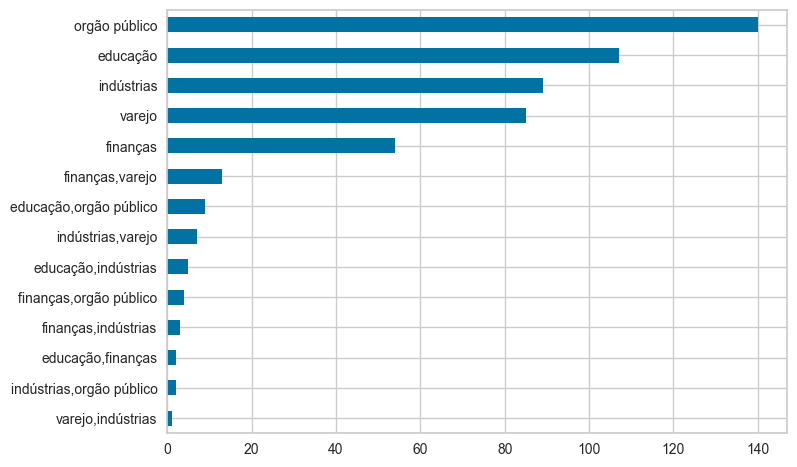

In [160]:
df.category.value_counts().sort_values().plot(kind = 'barh')

Algumas das categorias são coletivas, possuindo 2 classificações no máximo por texto, para solucionarmos esse problema iremos separar as categorias individuais

In [161]:
dummies = df['category'].str.get_dummies(sep=',')
df[dummies.columns] = dummies

Feito isso temos 5 colunas com 0s e 1s indicando se aquela sentença pertence a classe correspondente [1 para sim e 0 para não] - Esse método é chamado de **One-hot-encoding**

In [162]:
df.head(5)

,sentence,category,educação,finanças,indústrias,orgão público,varejo
0,"Auxílio-Doença Previdenciário, Benefícios em E...",orgão público,0,0,0,1,0
1,"PAGAR TODAS AS CONTAS EM ATRASO R$1.290,90.",finanças,0,1,0,0,0
2,Então encontraremos na próxima aula.,educação,1,0,0,0,0
3,Veja os resultados da categoria de ofertas do ...,indústrias,0,0,1,0,0
4,"Além disso, a embalagem é reutilizável e 100% ...","indústrias,varejo",0,0,1,0,1


Removemos os caracteres especiais das colunas

In [163]:
df.columns = df.columns.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df.columns

Index(['sentence', 'category', 'educacao', 'financas', 'industrias',
       'orgao publico', 'varejo'],
      dtype='object')

Iremos remover a coluna *category*, não precisamos mais dela no momento

In [164]:
df.drop(columns=['category'], inplace=True)
df.head(5)

,sentence,educacao,financas,industrias,orgao publico,varejo
0,"Auxílio-Doença Previdenciário, Benefícios em E...",0,0,0,1,0
1,"PAGAR TODAS AS CONTAS EM ATRASO R$1.290,90.",0,1,0,0,0
2,Então encontraremos na próxima aula.,1,0,0,0,0
3,Veja os resultados da categoria de ofertas do ...,0,0,1,0,0
4,"Além disso, a embalagem é reutilizável e 100% ...",0,0,1,0,1


In [165]:
df.apply(pd.Series.value_counts)

,sentence,educacao,financas,industrias,orgao publico,varejo
0,NaN,398.0,445.0,414.0,366.0,415.0
1,NaN,123.0,76.0,107.0,155.0,106.0
Compre na web e saia com dinheiro no bolso!,1.0,NaN,NaN,NaN,NaN,NaN
O seu carrinho já tem 17 itens.,1.0,NaN,NaN,NaN,NaN,NaN
Temos preços especiais e retirada na loja.,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
Você só pagará a tarifa por este serviço uma vez por mês.,1.0,NaN,NaN,NaN,NaN,NaN
programa de aprendizagem,1.0,NaN,NaN,NaN,NaN,NaN
É só ir ao caixa eletrônico do Itaú mais próximo com o seu cartão da conta corrente,1.0,NaN,NaN,NaN,NaN,NaN
É uma forma do investidor se programar para a realização dos seus objetivos.,1.0,NaN,NaN,NaN,NaN,NaN


Quantidade de valor por classe em estudo

<AxesSubplot: >

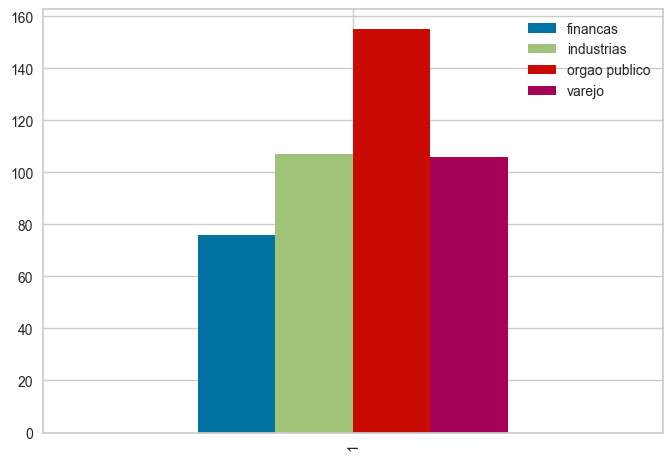

In [166]:
df.iloc[:,-4:].apply(pd.Series.value_counts).tail(1).plot(kind='bar')


## Tratamento do Texto e Processamento de Linguagem Natural

Nesta seção iremos tratar o texto de nosso dataset e transforma-lo em um padrão no qual poderemos gerar um classificador multi-label

In [167]:
#!pip install nltk

In [168]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
import nltk

Estamos importando as stopwords (preposições) que atrapalham nosso processamento e modelagem

In [169]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')
stopwords[:5]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['a', 'à', 'ao', 'aos', 'aquela']

In [170]:
#Não há missing data in sentence
df.sentence.isna().sum()

0

In [171]:
import re
def clean_text(data):
    data['text_without_stopwords'] = data['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)])\
        .lower().encode('ascii', errors='ignore').decode('utf-8'))    

    return data

In [172]:
#!pip install unidecode

In [173]:
import re
import unidecode

def clean_text(data):
    data['text_without_stopwords'] = data['sentence'].apply(lambda x:unidecode.unidecode(re.sub(r'[.,"\'-?:!;]', ' ', ' '.\
        join([word for word in x.split() if word not in (stopwords)])).lower()))    

    return data

In [174]:
df_clean = clean_text(df)

In [175]:
df_clean.drop(columns=["sentence"], inplace=True)
df_clean

,educacao,financas,industrias,orgao publico,varejo,text_without_stopwords
0,0,0,0,1,0,auxilio doenca previdenciario beneficios espe...
1,0,1,0,0,0,pagar todas as contas em atraso r$
2,1,0,0,0,0,entao encontraremos proxima aula
3,0,0,1,0,0,veja resultados categoria ofertas novo modelo ...
4,0,0,1,0,1,alem disso embalagem reutilizavel % recicl...
...,...,...,...,...,...,...
516,1,0,0,0,0,selecione local estudo curso encontros presen...
517,1,0,0,1,0,estudantes da rede municipal voltam as aulas e...
518,0,0,0,1,0,empresas orgaos publicos
519,0,0,0,1,0,dge - departamento gestao estrategica metas na...


Após limparmos o texto de stop words e deixa-lo em lowercase utilizaremos a ferramenta do TfidfVectorizer, o qual transformará as palavras do corpus (texto de sentence) em vetores que podem ser trabalhados.
Nesse contexto estaremos utilizando BOW (Bag of Words) e TF-IDF

Aqui esta um exemplo de aplicação:


In [176]:
df_clean.head(3)

,educacao,financas,industrias,orgao publico,varejo,text_without_stopwords
0,0,0,0,1,0,auxilio doenca previdenciario beneficios espe...
1,0,1,0,0,0,pagar todas as contas em atraso r$
2,1,0,0,0,0,entao encontraremos proxima aula


In [177]:
cleanTrain, cleanTest = train_test_split(df_clean, random_state=42, test_size=0.33, shuffle=True)

c:\Users\victo\anaconda3\envs\dev\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


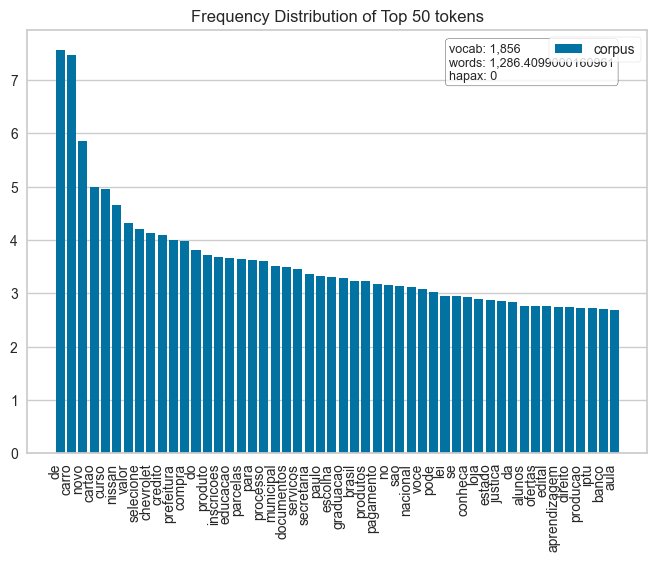

Aqui podemos ver a correlação entre as palavras e suas 'proximidades'


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


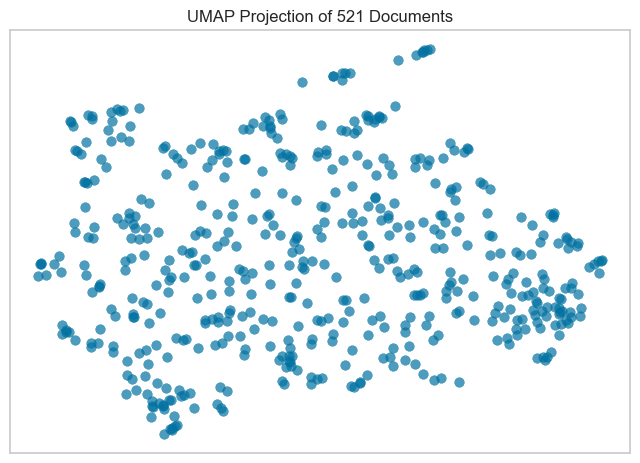

In [178]:
from yellowbrick.text import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = TfidfVectorizer()
vector_train_text = vectorizer.fit_transform(df_clean["text_without_stopwords"])
#vector_test_text =  vectorizer.fit_transform(cleanTest["text_without_stopwords"])
features = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(vector_train_text)
visualizer.show()

print("Aqui podemos ver a correlação entre as palavras e suas 'proximidades'")
from yellowbrick.text import UMAPVisualizer

umap = UMAPVisualizer(metric="cosine")
umap.fit(vector_train_text)
umap.show()

vector_test_text =  vectorizer.fit_transform(cleanTest["text_without_stopwords"])

In [179]:
df_clean.iloc[ : , :5].values

array([[0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0]], dtype=int64)

In [180]:


X_train, X_test, y_train, y_test = train_test_split(df['text_without_stopwords'], df_clean.iloc[ : , :5].values, random_state = 32, test_size=0.1)

#Usando TfIdf
tfidf = TfidfVectorizer(
    sublinear_tf= True,
    lowercase=True,
    analyzer='word',
    norm= 'l2', 
    ngram_range= (1,1),
    use_idf=True,
    binary=False,
    smooth_idf=True 
)

bow = TfidfVectorizer(
    binary=False,
    norm=None,
    use_idf=False,
    smooth_idf=False,
    lowercase=True,
    min_df= 1,
    max_features=None,
    ngram_range=(1,1)
)

tfidf.fit_transform(df['text_without_stopwords'])
X_train_counts = tfidf.transform(X_train)
X_test_counts = tfidf.transform(X_test)

X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)


## Modelagem

Nesta etapa iremos criar um Pipeline aplicar um modelo classificador no nosso conjunto de dados
Inicialmente iremos realizar multi classificações binárias utilizando modelos mais simples, a seguir iremos partir para um modelo mais complexto de classificação multilabel

### Multi-classificação binária

In [181]:
categories = df.columns[0:5]
categories

Index(['educacao', 'financas', 'industrias', 'orgao publico', 'varejo'], dtype='object')

Separando nosso conjunto de treino e teste

In [182]:
train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)

In [183]:
X_train = train.text_without_stopwords
X_test = test.text_without_stopwords

In [184]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stopwords)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
for category in categories:
    print('Treinando a categoria {}...'.format(category))
    NB_pipeline.fit(X_train, train[category])
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))


Treinando a categoria educacao...
Test accuracy is 0.7616279069767442
Treinando a categoria financas...
Test accuracy is 0.877906976744186
Treinando a categoria industrias...
Test accuracy is 0.8604651162790697
Treinando a categoria orgao publico...
Test accuracy is 0.872093023255814
Treinando a categoria varejo...
Test accuracy is 0.7790697674418605


### Classificação Multilabel

Vetorizando os valores textuais do nosso dataframe

In [186]:
[2, 5, 10]

[2, 5, 10]

Nesta seção estamos utilizando o estimador junto ao RandomizedSearchCV, assim obtermos os melhores hyperparametros do nosso modelo

In [187]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost as xgb
from scipy.stats import uniform

In [188]:
model_grid = ExtraTreesClassifier()
param_grid = {'n_estimators': [500,1000,2000],
            'min_samples_split': [2, 5, 10]}     
clf_cv = GridSearchCV(estimator = model_grid,  param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, scoring='f1_weighted')
search = clf_cv.fit(X_train_counts, y_train)
best_params_extra_trees = search.best_params_
best_params_extra_trees

Fitting 5 folds for each of 9 candidates, totalling 45 fits


{'min_samples_split': 2, 'n_estimators': 500}

Modelos utilizando TFIDF

In [189]:
model_one = OneVsRestClassifier(xgb.XGBClassifier(n_estimators=1000)).fit(X_train_counts, y_train)

In [190]:
rf = ExtraTreesClassifier(**best_params_extra_trees)
rf.fit(X_train_counts, y_train)
rf

ExtraTreesClassifier(n_estimators=500)

Modelos utilizando BOW

In [191]:
model_bow = OneVsRestClassifier(xgb.XGBClassifier(n_estimators=100)).fit(X_train_bow, y_train)

In [192]:
rf_bow = ExtraTreesClassifier(n_estimators=1000).fit(X_train_bow, y_train)

Predição utilizando os modelos criados

In [193]:
predicted_labels_one = model_one.predict(X_test_counts)
predicted_labels_one_bow = model_bow.predict(X_test_bow)

In [194]:
predicted_labels = rf.predict(X_test_counts)
predicted_labels_bow = rf_bow.predict(X_test_bow)

#### Métricas

Utilizando principalmente o F1-Score como medida de desempenho de nosso modelo, essa métrica é baseada na média harmônica entre Recall e Precision no qual também estaremos analisando nesse problema de classificação multitarget, por ser um problema com mais de uma classe precisamos da média dessas métricas.

In [195]:
from sklearn.metrics import average_precision_score


def print_evaluation_scores(y_test, predicted):
    
    print('Accuracy: ', accuracy_score(y_test, predicted, normalize=False))
    print('F1-score macro: ', f1_score(y_test, predicted, average='macro'))
    print('F1-score micro: ', f1_score(y_test, predicted, average='micro'))
    print('F1-score weighted: ', f1_score(y_test, predicted, average='weighted'))
    print('Precision macro: ', average_precision_score(y_test, predicted, average='macro'))
    print('Precision micro: ', average_precision_score(y_test, predicted, average='micro'))
    print('Precision weighted: ', average_precision_score(y_test, predicted, average='weighted'))

Matriz de Confusão para ExtraTreesClassifier

In [196]:
from sklearn.metrics import multilabel_confusion_matrix
print(multilabel_confusion_matrix(predicted_labels, y_test))

[[[41  5]
  [ 1  6]]

 [[45  5]
  [ 0  3]]

 [[41  3]
  [ 0  9]]

 [[28  3]
  [12 10]]

 [[39  6]
  [ 0  8]]]


Matriz de Confusão para OneVsRestClassifier

In [197]:
from sklearn.metrics import multilabel_confusion_matrix
print(multilabel_confusion_matrix(predicted_labels_one, y_test))

[[[40  6]
  [ 2  5]]

 [[41  5]
  [ 4  3]]

 [[40  2]
  [ 1 10]]

 [[39 10]
  [ 1  3]]

 [[38  7]
  [ 1  7]]]


Métricas de Avaliação de ExtraTreesClassifier

In [198]:
#TFIDF
print_evaluation_scores(y_test,predicted_labels)

Accuracy:  32
F1-score macro:  0.6735930735930736
F1-score micro:  0.6728971962616822
F1-score weighted:  0.6826391998805792
Precision macro:  0.585741145646806
Precision micro:  0.5390357574389548
Precision weighted:  0.5944959399741442


In [199]:
#BOW
print_evaluation_scores(y_test,predicted_labels_bow)

Accuracy:  30
F1-score macro:  0.6387878787878787
F1-score micro:  0.6346153846153846
F1-score weighted:  0.6430512016718913
Precision macro:  0.5459871417890285
Precision micro:  0.5025105371842381
Precision weighted:  0.5490717074077516


Métricas de Avaliação de OneVsRestClassifier

In [200]:
#TFIDF
print_evaluation_scores(y_test,predicted_labels_one)

Accuracy:  22
F1-score macro:  0.5628851171562169
F1-score micro:  0.5894736842105263
F1-score weighted:  0.5731589641899193
Precision macro:  0.4839160053782695
Precision micro:  0.4785383952592801
Precision weighted:  0.5013408436066211


In [201]:
#BOW
print_evaluation_scores(y_test,predicted_labels_one_bow)

Accuracy:  22
F1-score macro:  0.5518128654970761
F1-score micro:  0.5555555555555556
F1-score weighted:  0.5509175236942931
Precision macro:  0.47667948403797455
Precision micro:  0.46127399154196486
Precision weighted:  0.48628125290454505


A partir daqui usaremos os testes do melhor classificador

C:\Users\victo\AppData\Local\Temp\ipykernel_20236\2494917428.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


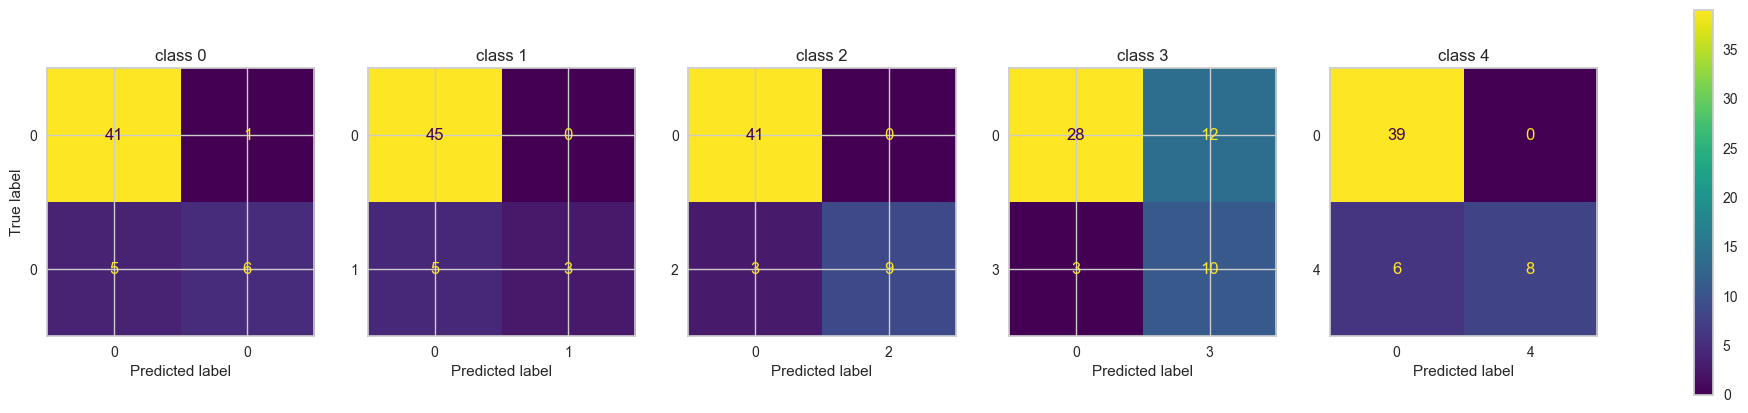

In [202]:
from sklearn.metrics import ConfusionMatrixDisplay


f, axes = plt.subplots(1, 5, figsize=(25, 5))
axes = axes.ravel()
for i in range(5):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test[:, i],
                                                   predicted_labels[:, i]),
                                  display_labels=[0, i])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class {i}')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()
f.colorbar(disp.im_, ax=axes)
plt.grid(b=None)
plt.show()


Aqui podemos realizar um teste com um input arbitrário e nosso modelo irá classificá-lo

In [203]:
def input_to_class(predictor, entrada):
    entrada = unidecode.unidecode(re.sub(r'[.,"\'-?:!;]', ' ', ' '.join([word for word in entrada.split() if word not in (stopwords)])).lower())
    singular = tfidf.transform(pd.Series([entrada]))
    resultado = predictor.predict(singular)
    colunas = df_clean.iloc[:, 0:5].columns
    for i in range(len(colunas)):
        if (resultado[0][i] == 1):
            print(colunas[i])

In [204]:
colunas = df_clean.iloc[:, 0:5].columns
colunas

Index(['educacao', 'financas', 'industrias', 'orgao publico', 'varejo'], dtype='object')

In [205]:
entrada = input()
input_to_class(rf, entrada)

orgao publico


Usando um exemplo da descrição do problema:

In [206]:
entrada = 'Curso de Técnico em Segurança do Trabalho por 32x R$ 161,03.'
input_to_class(rf, entrada)

educacao
financas


Ferramenta para a construção e execução de um modelo completo:

In [207]:
def build_model(df, n_grams, model, column, params, test_size):
    X_train, X_test, y_train, y_test = train_test_split(df[column], df_clean.iloc[ : , :5].values, random_state = 32, test_size=test_size)
    tfidf = TfidfVectorizer(
        sublinear_tf= True,
        lowercase=True,
        analyzer='word',
        norm= 'l2', 
        ngram_range= (1,n_grams),
        use_idf=True,
        binary=False,
        smooth_idf=True 
    )

    X_train_cts = tfidf.fit_transform(X_train)
    X_test_cts = tfidf.transform(X_test)

    model.set_params(**params)
    model.fit(X_train_cts, y_train)

    predicted_labels = model.predict(X_test_cts)

    print_evaluation_scores(y_test,predicted_labels)

In [208]:
model = RandomForestClassifier()
params = {'min_samples_split': 2, 'n_estimators': 2000}
build_model(df = df_clean, n_grams=2, model= model, column='text_without_stopwords', params=params, test_size=0.2)

Accuracy:  55
F1-score macro:  0.5942770780414401
F1-score micro:  0.6130653266331657
F1-score weighted:  0.6018189262421957
Precision macro:  0.5176926371413657
Precision micro:  0.4819453346269563
Precision weighted:  0.5196972226860355


### Utilizando Redes Neurais

In [209]:
#!pip install keras
#!pip install tensorflow

In [210]:
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
import numpy as np

In [211]:
df.sample(5)

,educacao,financas,industrias,orgao publico,varejo,text_without_stopwords
97,0,0,0,1,0,projeto de lei no
28,0,0,1,0,0,as marcas bmw chevrolet renault volkswagen ...
482,0,0,0,1,0,veja trajetoria debates projeto regularizacao ...
256,0,1,0,0,0,o brasil dispoe modernos sistemas bancarios pr...
341,0,0,0,0,1,gostaria saber valores shampoos


In [212]:
data = df.copy()

In [213]:
X = tfidf.fit_transform(data['text_without_stopwords'].values).toarray()
y = data.iloc[:,:5].values

In [214]:
tfidf.get_feature_names_out()

array(['abaixo', 'abastecimento', 'aberta', ..., 'xtronic', 'yara', 'zoe'],
      dtype=object)

In [215]:
X.shape, y.shape

((521, 1856), (521, 5))

In [216]:
def define_sequential_model(n_inputs, n_outputs):
	model = Sequential()
	model.add(Dense(256, input_dim=n_inputs, activation='relu'))
	model.add(Dense(n_outputs, activation='sigmoid'))
	model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
	return model

In [217]:
def evaluate_model(X, y):
	results = list()
	n_inputs, n_outputs = X.shape[1], y.shape[1]
	cv = RepeatedKFold(n_splits=3, n_repeats=3, random_state=1)
	for train_ix, test_ix in cv.split(X):
		# prepare data
		X_train, X_test = X[train_ix], X[test_ix]
		y_train, y_test = y[train_ix], y[test_ix]
		# define model
		model = define_sequential_model(n_inputs, n_outputs)
		# fit model
		history = model.fit(X_train, y_train, verbose=1, epochs=100)
		# make a prediction on the test set
		yhat = model.predict(X_test)
		# round probabilities to class labels
		yhat = yhat.round()
		# calculate accuracy
		acc = accuracy_score(y_test, yhat)

		print(acc)
	return results

In [218]:
evaluate_model(X,y)

Epoch 1/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6771 - accuracy: 0.2305
Epoch 2/100
11/11 [==============================] - 0s 4ms/step - loss: 0.6345 - accuracy: 0.6916
Epoch 3/100
11/11 [==============================] - 0s 4ms/step - loss: 0.5846 - accuracy: 0.8242
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.5274 - accuracy: 0.8617
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 0.4737 - accuracy: 0.8646
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.4294 - accuracy: 0.8818
Epoch 7/100
11/11 [==============================] - 0s 6ms/step - loss: 0.3898 - accuracy: 0.8934
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 0.3496 - accuracy: 0.9107
Epoch 9/100
11/11 [==============================] - 0s 6ms/step - loss: 0.3079 - accuracy: 0.9193
Epoch 10/100
11/11 [==============================] - 0s 6ms/step - loss: 0.2664 - accuracy: 0.9280
Epoch 11/

[]

In [317]:
n_inputs, n_outputs = X.shape[1], y.shape[1]
# get model
model = define_sequential_model(n_inputs, n_outputs)

print(model.summary())
# fit the model on all data
model.fit(X, y, verbose=1, epochs=100)

Model: "sequential_145"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_290 (Dense)           (None, 256)               475392    
                                                                 
 dense_291 (Dense)           (None, 5)                 1285      
                                                                 
Total params: 476,677
Trainable params: 476,677
Non-trainable params: 0
_________________________________________________________________
None


In [310]:

def input_to_class_nn(predictor, entrada, data):
    phrase = entrada
    phrase = unidecode.unidecode(re.sub(r'[.,"\'-?:!;]', ' ', ' '.join([word for word in phrase.split() if word not in (stopwords)])).lower())
    singular = tfidf.transform(pd.Series([phrase])).toarray()
    resultado = model.predict(singular, verbose=0)
    print('Probabilidades: ', [np.round(x,3) for x in resultado][0])
    colunas = data.iloc[:, 0:5].columns
    result_list = []
    for i in range(len(colunas)):
        if (resultado[0][i] > 0.5):
            result_list.append(1)
        else:
            result_list.append(0)

    series = pd.Series(result_list, index = colunas)
    df_out = series.to_frame()
    df_out.index.name = 'Categorias'
    df_out.rename(columns={df_out.columns[0]: 'isValid'},inplace=True)
    return df_out

In [314]:
entrada = 'quero um carro importado para ir no meu trabalho na prefeitura'
saida = input_to_class_nn(model, entrada, data)
saida

Probabilidades:  [0.003 0.498 0.035 0.033 0.003]


,isValid
Categorias,
educacao,0
financas,0
industrias,0
orgao publico,0
varejo,0


### Storing TF-IDF, Models and Data Columns

In [243]:
import keras as kr

In [242]:
import pickle


with open('tfidf.pickle', 'wb') as f:
    pickle.dump(tfidf, f, pickle.HIGHEST_PROTOCOL)

model.save('sequential_model')

with open('df_sample.pickle', 'wb') as f:
    pickle.dump(data.iloc[:, :5].head(1), f, pickle.HIGHEST_PROTOCOL)


INFO:tensorflow:Assets written to: sequential_model\assets


In [245]:
unpickled_df = pd.read_pickle("df_sample.pickle") 
unpickled_df

In [247]:
model_2.summary()

Model: "sequential_143"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_286 (Dense)           (None, 256)               475392    
                                                                 
 dense_287 (Dense)           (None, 5)                 1285      
                                                                 
Total params: 476,677
Trainable params: 476,677
Non-trainable params: 0
_________________________________________________________________
